# Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp

LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker       = xt.Tracker(line=line[_beam])
        twiss[_beam]  = tracker.twiss().to_pandas(index="name")
        survey[_beam] = tracker.survey().to_pandas(index="name")
    elif _beam == 'b4':
        _tracker      = xt.Tracker(line=line[_beam])
        twiss['b2']   = _tracker.twiss().reverse().to_pandas(index="name")
        survey['b2']  = _tracker.survey().reverse().to_pandas(index="name")


# Filtering twiss
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================

# Clearing xsuite ouput
clear_output(wait=False)

# Creating IP objects!

In [2]:
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)

--- 

# General IP plot

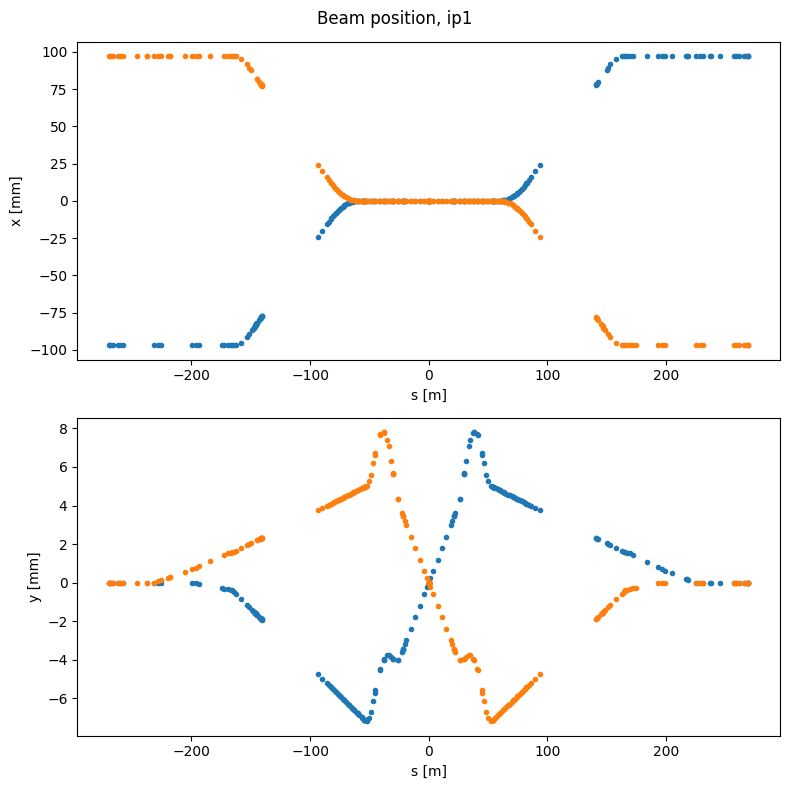

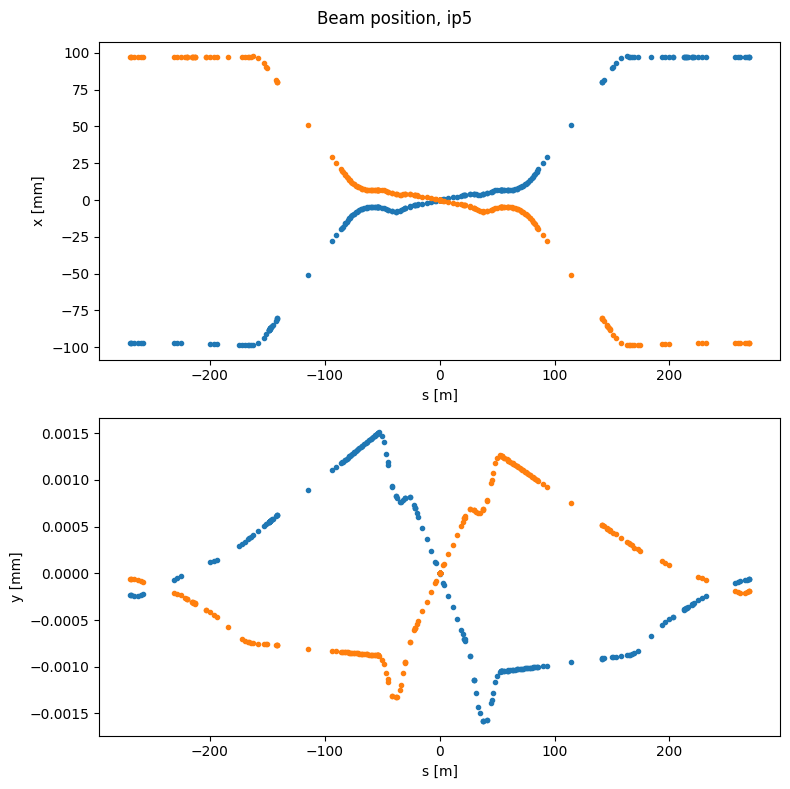

In [3]:
chosenIPs = ['ip1','ip5']
for _IP in chosenIPs:

    # ROI around IP
    ROI_twiss_b1,ROI_survey_b1 = inp.extract_IP_ROI(_IP,'b1',twiss['b1'],survey['b1'])
    ROI_twiss_b2,ROI_survey_b2 = inp.extract_IP_ROI(_IP,'b2',twiss['b2'],survey['b2'])

  
    # Plotting
    
    fig, axes = plt.subplots(2, 1,figsize=(8,8))
    fig.suptitle(f'Beam position, {_IP}')
    for plane,ax in zip(['x','y'],axes.flatten()):
        
        center = ROI_twiss_b1.loc[_IP,f'{plane}_lab']
        ax.plot(ROI_twiss_b1['s_lab'],(ROI_twiss_b1[f'{plane}_lab']-center)/1e-3,'.')
        ax.plot(ROI_twiss_b2['s_lab'],(ROI_twiss_b2[f'{plane}_lab']-center)/1e-3,'.')
        
            
    
        ax.set(xlabel='s [m]', ylabel=f'{plane} [mm]')
        
    plt.tight_layout()

# Using the IP objects

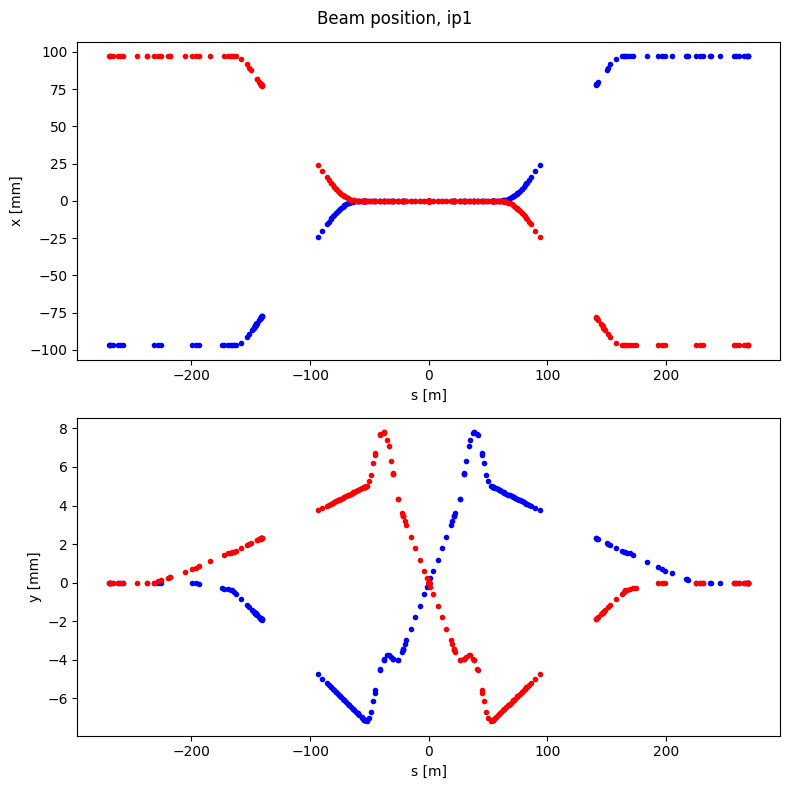

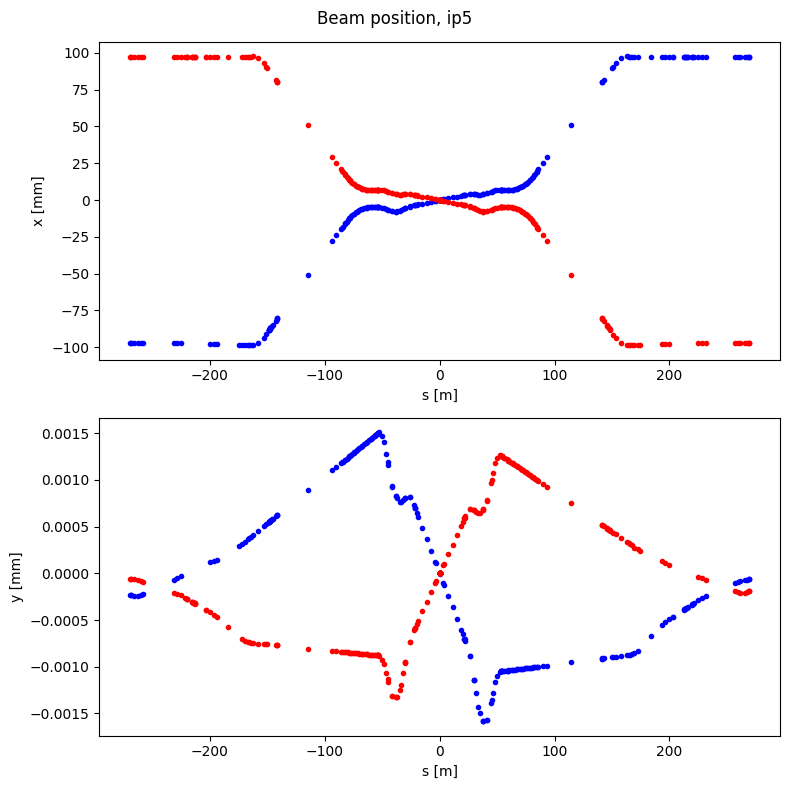

In [4]:
chosenIPs = ['ip1','ip5']
for _IP in [IP1,IP5]:

  
    # Plotting
    
    fig, axes = plt.subplots(2, 1,figsize=(8,8))
    fig.suptitle(f'Beam position, {_IP.name}')
    for plane,ax in zip(['x','y'],axes.flatten()):
        center = _IP.b1.twiss.loc[_IP.name,f'{plane}_lab']
        ax.plot(_IP.b1.twiss['s_lab'],(_IP.b1.twiss[f'{plane}_lab']-center)/1e-3,'.b')
        ax.plot(_IP.b2.twiss['s_lab'],(_IP.b2.twiss[f'{plane}_lab']-center)/1e-3,'.r')
        
            
    
        ax.set(xlabel='s [m]', ylabel=f'{plane} [mm]')
        
    plt.tight_layout()

# Beam-beam separation

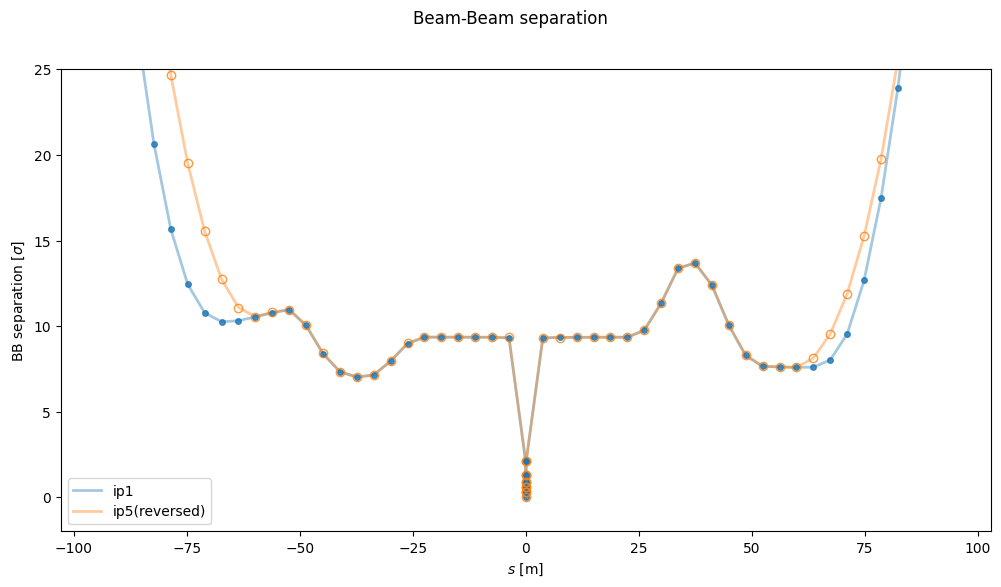

In [5]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_n_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_n_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])